In [3]:
import numpy as np

# Loading the dataset
dataset = np.load('qm7x_eq.npz', allow_pickle=True)

# What is inside?
for f in dataset.files:
    print(f)

EAT
S
xyz
Z


In [4]:
# Importing data
EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic indexes

n_molecules = len(xyz)
print('The number of molecules in the dataset is {:d}.'.format(n_molecules))

The number of molecules in the dataset is 41537.


In [5]:
from tqdm import tqdm
from scipy.spatial.distance import pdist

# Descriptor
def descriptor(R):
    
    nconfig = len(R)
    D = []
    for i in tqdm(range(nconfig)):
        D.append(1./pdist(R[i]))
    
    return D

d = descriptor(xyz)

# Making all descriptor entries of the same size
max_size = np.max([len(_) for _ in d])
nconfig = len(d)
D = np.zeros((nconfig, max_size))

for i in range(nconfig):
    size = len(d[i])
    D[i, :size] = d[i]

 11%|█         | 4530/41537 [00:00<00:02, 14784.84it/s]

100%|██████████| 41537/41537 [00:02<00:00, 17017.66it/s]


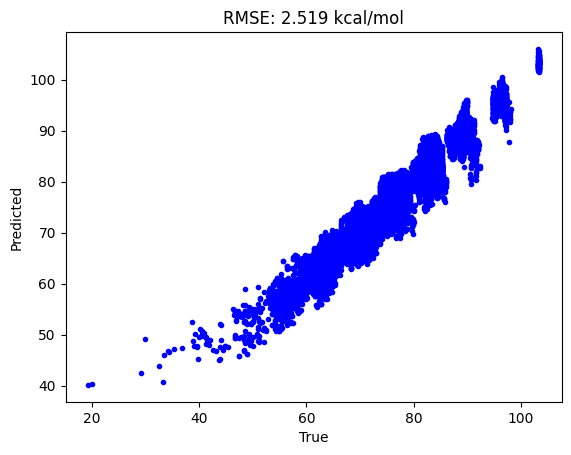

In [6]:
from sklearn import linear_model
import matplotlib.pyplot as plt

# ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(D, EAT)

rmse = np.sqrt(np.square(EAT - reg.predict(D)).mean())
plt.title('RMSE: {:.3f} kcal/mol'.format(rmse))
plt.scatter(EAT, reg.predict(D), marker='.', color='blue')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import pdist
from sklearn import linear_model
import matplotlib.pyplot as plt

# Loading the dataset
dataset = np.load('qm7x_eq.npz', allow_pickle=True)

# Importing data
EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic indexes

# Descriptor
def descriptor(R):
    
    nconfig = len(R)
    D = []
    # iterate through each coordinate triplet
    for i in tqdm(range(nconfig)):
        D.append(np.concatenate((1./pdist(R[i]), Z[i])))
    
    return D

d = descriptor(xyz)

# Making all descriptor entries of the same size
max_size = np.max([len(_) for _ in d])
nconfig = len(d)
D = np.zeros((nconfig, max_size))

for i in range(nconfig):
    size = len(d[i])
    D[i, :size] = d[i]
    

# ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(D, EAT)

rmse = np.sqrt(np.square(EAT - reg.predict(D)).mean())
plt.title('RMSE: {:.3f} kcal/mol'.format(rmse))
plt.scatter(EAT, reg.predict(D), marker='.', color='blue')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

  0%|          | 2/41537 [00:06<38:44:27,  3.36s/it]


KeyboardInterrupt: 